# librarys

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import math
import random
import warnings
warnings.simplefilter('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from skrebate import ReliefF
from sklearn.model_selection import cross_val_score
from numpy import array
from mlxtend.feature_selection import ColumnSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from sklearn.externals.six import StringIO  
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
%matplotlib inline

# functions

In [2]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    #     print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
#     print('Kappa: {:.3f}'.format(cohen_kappa_score(y_test, y_pred)))
# #     print('F1 socre: {:.3f}'.format(f1_score(y_test, y_pred)))
# #     print('Recall socre: {:.3f}'.format(recall_score(y_test, y_pred)))
#     print(classification_report(y_test, y_pred))
    return(accuracy_score(y_test, y_pred))

def report(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Kappa: {:.3f}'.format(cohen_kappa_score(y_test, y_pred)))
    print('Recall socre: {:.3f}'.format(recall_score(y_test, y_pred,average='micro')))
    print('F1 socre: {:.3f}'.format(f1_score(y_test, y_pred, average='micro')))
#     print('Balanced accuracy socre: {:.3f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

def density_plot(locations, data, element):
    # Iterate through the 6 locations
    for location in locations:
        # Subset to the locations
        subset = data[data['lv'] == location]

        # Draw the density plot
#         sns.distplot(subset[element], hist = False, kde = True,

#                      label = location)
        sns.kdeplot(subset[element], bw = 0.1, label = location)
    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'locations')
    plt.title('Density Plot')
    plt.xlabel(element)
    plt.ylabel('Density')
    

def reliefF(data, label):
    x, y = data.drop(label, axis = 1).values, data[label].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 233, stratify = y)
    fs = ReliefF(n_jobs=-1, n_neighbors=len(x_train))
    fs.fit(x_train,y_train)
    relief_result = pd.DataFrame(columns = ['feature', 'score'])
    relief_result['score'] = fs.feature_importances_
    relief_result['feature'] =data.columns[1:len(data.columns)]
    relief_result=relief_result.sort_values(by=['score'], ascending=False)
    return relief_result

# data import

In [3]:
data = pd.read_csv("C:/Users/fzkon/Documents/GitHub/Rice_authenticity_ICP_new\grand.csv")



# Relief feature selection

In [4]:
relief_result = reliefF(data, 'lv')

In [5]:
relief_result.head()

,feature,score
3,Al,0.360728
0,B,0.351283
20,Rb,0.323673
1,Na,0.320262
8,V,0.313080


In [38]:
# relief_result.to_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/relief_result_python.csv", index=False)

# hyperparameter optimization for rf

In [7]:
# relief_result = pd.read_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/relief_result_python.csv")
relief_result = relief_result.sort_values(by=['score'], ascending=False)


In [8]:
x = data.loc[:, data.columns != 'lv']
y = data.loc[:, data.columns == 'lv']

In [9]:
data['lv'].describe()

count      131
unique       6
top       PJ-1
freq        35
Name: lv, dtype: object

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 233, stratify = y)

In [11]:
data['lv'].value_counts()

PJ-1    35
JS      20
SY      20
PJ-2    20
WC      20
GG      16
Name: lv, dtype: int64

In [12]:
y_test['lv'].value_counts()

PJ-1    7
GG      4
JS      4
SY      4
PJ-2    4
WC      4
Name: lv, dtype: int64

In [17]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [int(x) for x in np.linspace(start=1, stop = 101, num = 5)],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
    }
rf = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1)

summary = pd.DataFrame(columns=['number of features', 'training accuracy', 'testing accuracy'])

training_accuracy =[]
testing_accuracy = []
features = []

for i in range(1, 5+1):
    print("i am in the cycle of", i)
    mask = relief_result['feature'][0:i]
    x_temp = x[mask]
    x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 233, stratify = y)
    grid_search.fit(x_train, y_train)
    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, x_test, y_test)
    training_accuracy.append(grid_search.best_score_)
    testing_accuracy.append(grid_accuracy)
    features.append(list(mask))
#     if grid_search.best_score_ == 1:
#         print("i have reached 100% accuracy")
#         print(grid_search.best_params_)
#         break
    

i am in the cycle of 1
i am in the cycle of 2
i am in the cycle of 3
i am in the cycle of 4
i am in the cycle of 5


In [18]:
summary['number of features'] = features
summary['training accuracy'] = training_accuracy
summary['testing accuracy'] = testing_accuracy
    
print(summary)
# summary.to_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/rf_result.csv", 
#                index=True)

   number of features  training accuracy  testing accuracy
0                [Al]           0.546364          0.629630
1             [Al, B]           0.787273          0.629630
2         [Al, B, Rb]           0.875455          0.925926
3     [Al, B, Rb, Na]           1.000000          1.000000
4  [Al, B, Rb, Na, V]           0.990000          1.000000


In [61]:
# do not delete me!!!!
summary['number of features'] = features
summary['training accuracy'] = training_accuracy
summary['testing accuracy'] = testing_accuracy
    
print(summary)
# summary.to_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/rf_result.csv", 
#                index=True)

  number of features  training accuracy  testing accuracy
0               [Al]           0.536364          0.629630
1            [Al, B]           0.787273          0.629630
2        [Al, B, Rb]           0.866364          0.888889
3    [Al, B, Rb, Na]           1.000000          1.000000


In [52]:
rf_best = RandomForestClassifier(n_jobs=-1, max_depth=37, max_features='auto', n_estimators=200, bootstrap=True)

In [29]:
mask = relief_result['feature'][0:4]
x_temp = x[mask]
x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 23)

In [30]:
rf_best.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=37, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [103]:
rf_prob = pd.DataFrame(rf_best.predict_proba(x_test))


In [104]:
rf_prob.to_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/rf_prob.csv")

In [106]:
report(rf_best, x_test, y_test)

Accuracy: 1.000
Kappa: 1.000
Recall socre: 1.000
F1 socre: 1.000
              precision    recall  f1-score   support

          GG       1.00      1.00      1.00         4
          JS       1.00      1.00      1.00         2
        PJ-1       1.00      1.00      1.00         9
        PJ-2       1.00      1.00      1.00         4
          SY       1.00      1.00      1.00         3
          WC       1.00      1.00      1.00         5

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



# hyperparameter optimization for svm

In [20]:
from sklearn import svm

In [21]:
param_grid = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                     'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel':['poly'], 'degree':[0, 1, 2, 3, 4, 5, 6]}
             ]
svm = svm.SVC()
grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, 
                          cv = 10, n_jobs = -1)

summary = pd.DataFrame(columns=['number of features', 'training accuracy', 'testing accuracy'])

training_accuracy =[]
testing_accuracy = []
features = []

for i in range(1, 5+1):
    print("i am in the cycle of", i)
    mask = relief_result['feature'][0:i]
    x_temp = x[mask]
    x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 233, stratify = y)
    grid_search.fit(x_train, y_train)
    best_grid = grid_search.best_estimator_
    grid_accuracy = evaluate(best_grid, x_test, y_test)
    training_accuracy.append(grid_search.best_score_)
    testing_accuracy.append(grid_accuracy)
    features.append(list(mask))
#     if grid_search.best_score_ == 1:
#         print("i have reached 100% accuracy")
#         print(grid_search.best_params_)
#         break
    


i am in the cycle of 1
i am in the cycle of 2
i am in the cycle of 3
i am in the cycle of 4
i am in the cycle of 5


In [22]:
summary['number of features'] = features
summary['training accuracy'] = training_accuracy
summary['testing accuracy'] = testing_accuracy
    

print(summary)

   number of features  training accuracy  testing accuracy
0                [Al]           0.640909          0.555556
1             [Al, B]           0.827273          0.740741
2         [Al, B, Rb]           0.866364          0.888889
3     [Al, B, Rb, Na]           1.000000          1.000000
4  [Al, B, Rb, Na, V]           1.000000          1.000000


In [59]:
summary.to_csv("/Users/analytical/Documents/GitHub/Rice_authenticity_ICP_new/svm_result.csv", 
               index=True)

In [79]:
mask = relief_result['feature'][0:4]
x_temp = x[mask]
x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size = 0.2, random_state = 23)

In [98]:

svm = SVC(kernel='rbf', gamma=0.1, C=1,probability=True)

svm.fit(x_train, y_train)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [100]:
svm_prob  = svm.predict_proba(x_test)

In [108]:
report(svm, x_test, y_test)

Accuracy: 1.000
Kappa: 1.000
Recall socre: 1.000
F1 socre: 1.000
              precision    recall  f1-score   support

          GG       1.00      1.00      1.00         4
          JS       1.00      1.00      1.00         2
        PJ-1       1.00      1.00      1.00         9
        PJ-2       1.00      1.00      1.00         4
          SY       1.00      1.00      1.00         3
          WC       1.00      1.00      1.00         5

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [107]:
probs = svm.predict_proba(x_test)

## Starting of density plot

In [51]:
locations = ['JS', 'SY', 'WC', 'PJ-1', 'PJ-2', 'GG']

Al

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,8.624013,0.316711,7.851596,8.442039,8.689004,8.826498,9.069712
JS,20.0,10.522208,0.187829,10.271241,10.428438,10.487114,10.547028,11.141914
PJ-1,35.0,11.126173,0.483185,10.514673,10.684176,10.900764,11.558639,11.875304
PJ-2,20.0,8.329455,0.259466,7.979371,8.093455,8.304393,8.443683,8.993124
SY,20.0,8.624663,0.286979,8.093969,8.425880,8.632160,8.792685,9.199098
WC,20.0,9.001860,0.332381,8.612122,8.756477,8.918600,9.202102,9.648766


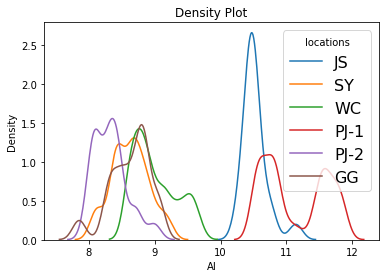

In [79]:
density_plot(locations, data, elements[0])

data.groupby('lv')[elements[0]].describe()

Rb

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,11.075358,0.352862,10.471864,10.816727,11.057128,11.266772,11.652005
JS,20.0,10.472157,0.115461,10.262857,10.380405,10.485515,10.527730,10.670491
PJ-1,35.0,9.040235,0.239654,8.649233,8.826450,8.996238,9.144450,9.558324
PJ-2,20.0,9.976119,0.252306,9.451244,9.857604,9.963220,10.100789,10.521417
SY,20.0,10.191141,0.401686,9.391915,9.895441,10.275018,10.556983,10.656619
WC,20.0,11.061249,0.121203,10.758231,11.008951,11.066301,11.129656,11.306991


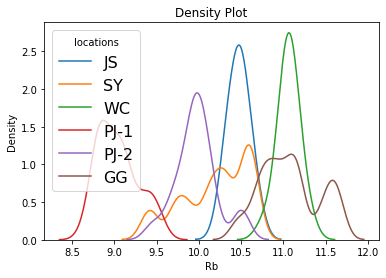

In [80]:
density_plot(locations, data, elements[1])

data.groupby('lv')[elements[1]].describe()

B

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,8.608929,0.151893,8.414138,8.485398,8.619523,8.713711,8.957043
JS,20.0,8.228153,0.176032,7.949523,8.109330,8.224519,8.341984,8.538336
PJ-1,35.0,9.498883,0.150733,9.271032,9.345774,9.524120,9.602598,9.865923
PJ-2,20.0,8.724303,0.161791,8.531818,8.596108,8.709689,8.799071,9.141318
SY,20.0,8.773493,0.172515,8.413383,8.722515,8.764233,8.877779,9.061104
WC,20.0,8.317846,0.129273,8.081510,8.233997,8.297705,8.400287,8.582795


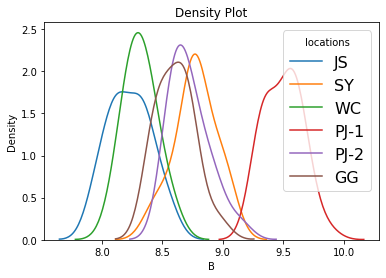

In [81]:
density_plot(locations, data, elements[2])

data.groupby('lv')[elements[2]].describe()

Na

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,11.018553,0.135075,10.690648,10.964562,11.018809,11.081639,11.284492
JS,20.0,10.198283,0.150670,9.958060,10.112575,10.174899,10.273606,10.556151
PJ-1,35.0,13.692792,0.526023,12.890923,13.410102,13.596794,13.890301,15.277934
PJ-2,20.0,12.542984,0.155666,12.301597,12.420788,12.552847,12.655318,12.814392
SY,20.0,14.270297,0.227569,13.810504,14.124509,14.268878,14.374482,14.731285
WC,20.0,12.364394,0.155194,12.161844,12.254887,12.351063,12.404490,12.767970


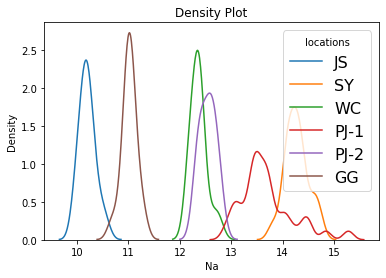

In [82]:
density_plot(locations, data, elements[3])

data.groupby('lv')[elements[3]].describe()

Sr

,count,mean,std,min,25%,50%,75%,max
lv,,,,,,,,
GG,16.0,6.049641,0.310342,5.548267,5.847216,6.093461,6.366289,6.455451
JS,20.0,5.846493,0.135372,5.558666,5.753265,5.853054,5.972913,6.026114
PJ-1,35.0,7.162524,0.235289,6.689166,7.032692,7.107160,7.334919,7.726865
PJ-2,20.0,6.609921,0.099042,6.474712,6.545891,6.588478,6.677076,6.862829
SY,20.0,5.816905,0.145444,5.390736,5.762157,5.813897,5.912568,6.101661
WC,20.0,6.239754,0.131056,5.947503,6.143932,6.225363,6.310253,6.527602


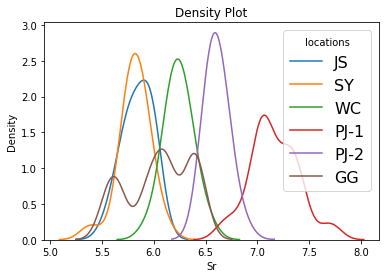

In [83]:
density_plot(locations, data, elements[4])

data.groupby('lv')[elements[4]].describe()

# construction of decision tree 

In [86]:
data['lv'].value_counts()

PJ-1    35
PJ-2    20
SY      20
JS      20
WC      20
GG      16
Name: lv, dtype: int64

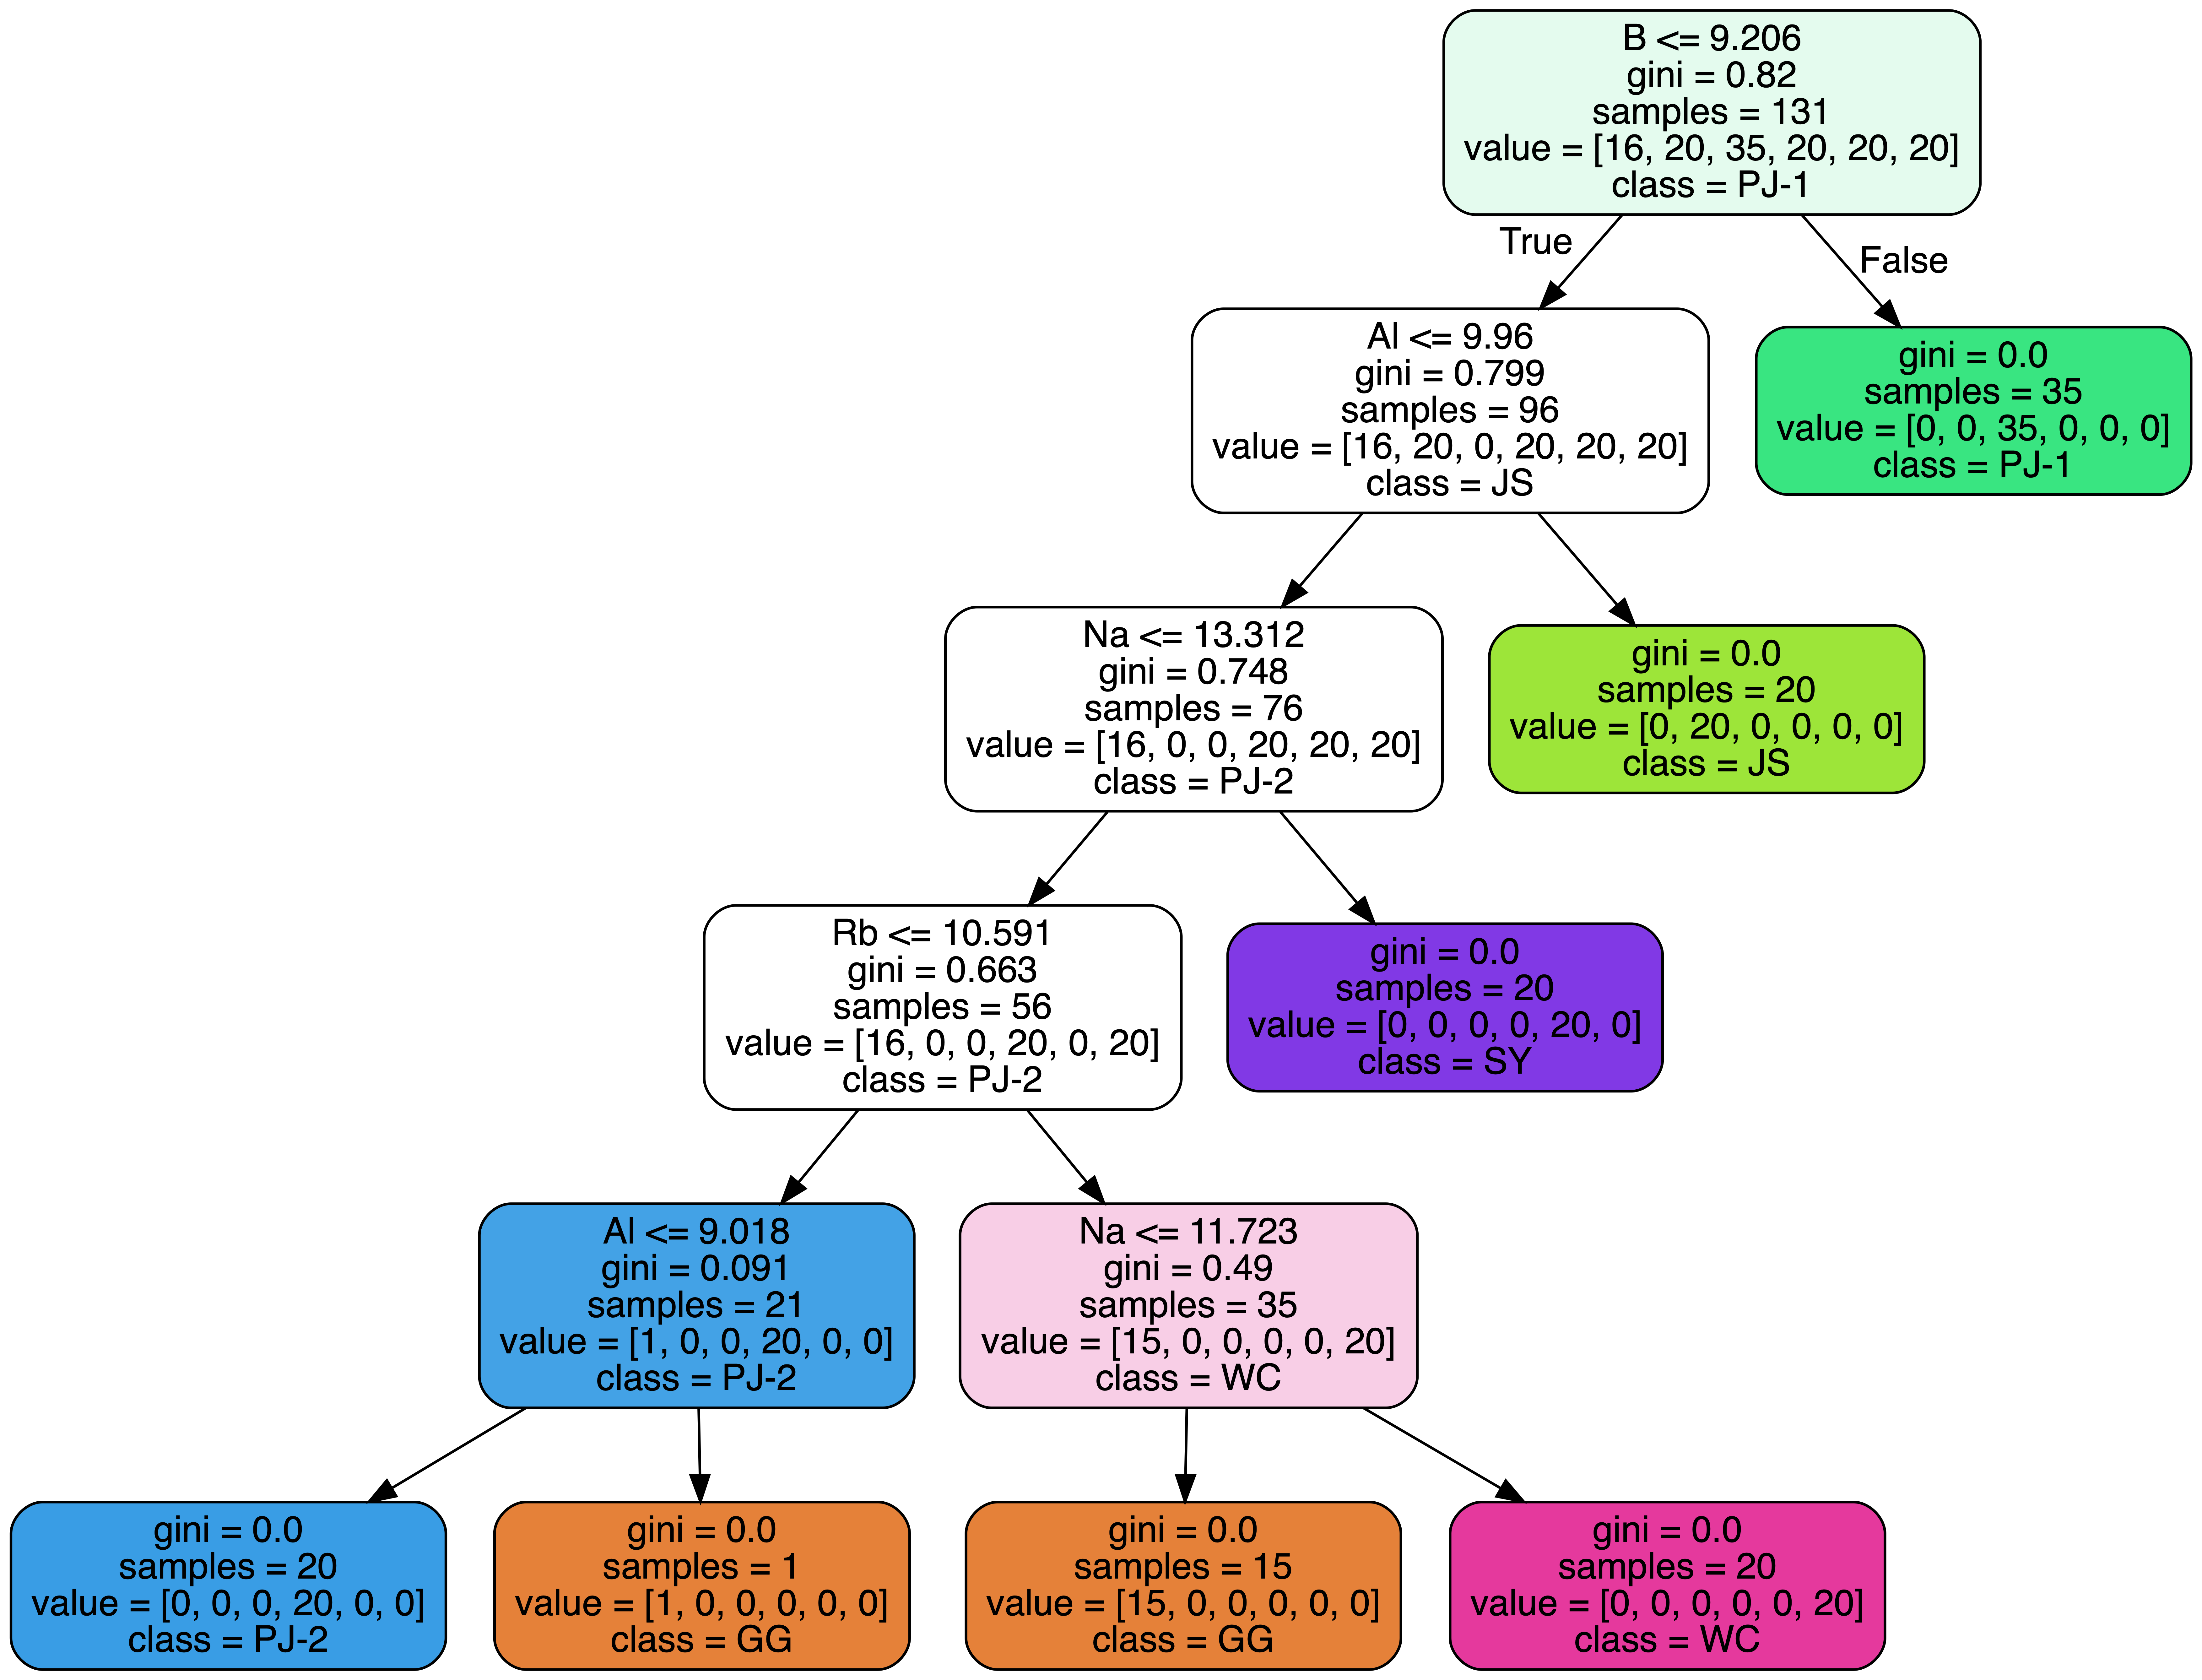

In [84]:
relief_result = pd.read_csv("/Users/analytical/Desktop/GFSC/Projects/Rice Authentication Project/Rice-authentication-ICP-MS/relief_result_python.csv")

relief_result = relief_result.sort_values(by=['score'], ascending=False)

elements = list(relief_result['feature'][0:5])

x_tree = x[elements]

x_names = x_tree.columns
x_names = x_names.tolist()

y_names = ['GG', 'JS', 'PJ-1', 'PJ-2', 'SY', 'WC']

dtc = DecisionTreeClassifier(random_state=296)
sample_split_range = list(range(1, 50))
param_grid = dict(min_samples_split=sample_split_range)
grid = GridSearchCV(dtc, param_grid, cv = 20, scoring='accuracy')
grid.fit(x_tree, y)
tree = grid.best_estimator_


# Extract single tree

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(tree, out_file='tree.dot', 
                feature_names = x_names,
                class_names = y_names,
                rounded = True, proportion = False, 
                precision = 3, filled = True, max_depth=7)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')